In [1]:
!pip install pandas scikit-learn xgboost
!pip install boostaroota

In [2]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Load Dataset

file_path = "/Users/Sebastiano/NeuroLupus_ML/ML_MRI copy.xlsx"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,0,38,1,Mood abnormalities (depressive),0.67586,42.3566,438.3091,35.4223,438.2523,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
3,Paziente 4,0,31,1,Seizure,0.65564,44.8080,424.9121,35.6460,424.8701,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
4,Paziente 5,0,43,0,Na,0.76373,94.5834,548.5729,41.4234,547.8604,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [6]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [7]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [8]:
# Define your features and target variable
X = df.drop(['NP-SLE'], axis=1) 
y = df['NP-SLE']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['SLE', 'NPSLE', 'Control'])

# Print the results
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

         SLE       1.00      0.50      0.67         4
       NPSLE       0.50      1.00      0.67         2
     Control       1.00      1.00      1.00         4

    accuracy                           0.80        10
   macro avg       0.83      0.83      0.78        10
weighted avg       0.90      0.80      0.80        10



In [9]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, missing=1, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [10]:
print(y_train)

8     1
3     1
6     0
40    2
33    2
13    1
17    0
44    2
15    0
9     1
16    0
29    2
32    2
45    2
0     1
31    2
30    2
5     0
11    0
34    2
1     0
41    2
21    1
2     0
35    2
23    1
37    2
10    1
22    1
18    1
46    2
20    0
7     1
42    2
14    1
28    2
38    2
Name: NP-SLE, dtype: int64


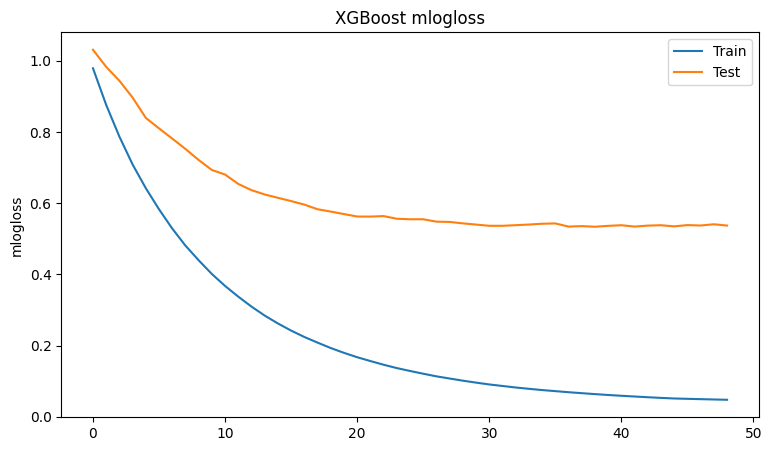

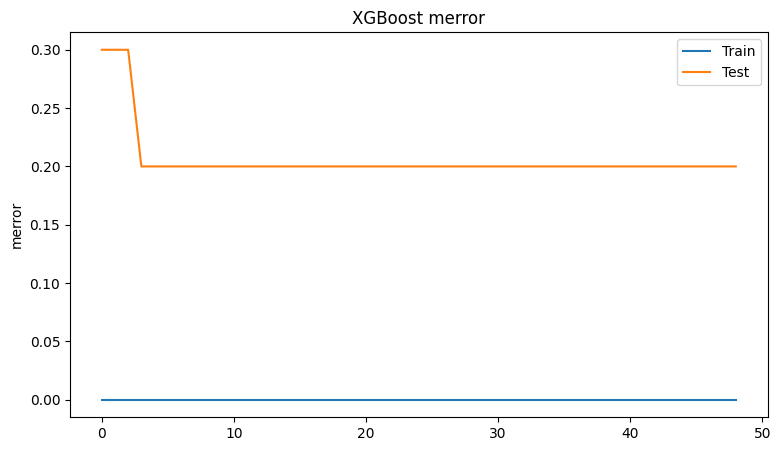


------------------ Confusion Matrix -----------------

[[2 2 0]
 [0 2 0]
 [0 0 4]]

Accuracy: 0.80
Balanced Accuracy: 0.83

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.83
Macro Recall: 0.83
Macro F1-score: 0.78

Weighted Precision: 0.90
Weighted Recall: 0.80
Weighted F1-score: 0.80

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      1.00      0.67         2
           2       1.00      1.00      1.00         4

    accuracy                           0.80        10
   macro avg       0.83      0.83      0.78        10
weighted avg       0.90      0.80      0.80        10

---------------------- XGBoost ----------------------


In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define the hyperparameters for the XGBoost classifier
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'missing': 1,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'reg_lambda': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'early_stopping_rounds': 10,
    'eval_metric': ['merror', 'mlogloss'],
    'seed': 42
}

# Define the best hyperparameters
best_hyperparameters = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 1.0
}

# Update the xgb_params dictionary with the best hyperparameters
xgb_params.update(best_hyperparameters)

# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values

# Initialize and train the XGBoost classifier with the best hyperparameters
xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

# Prepare evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot mlogloss
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

# Plot merror
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror')
plt.show()

# Get predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Print confusion matrix and evaluation metrics
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------')


In [12]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Define the hyperparameters for the XGBoost classifier
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'missing': 1,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'reg_lambda': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'early_stopping_rounds': 10,
    'eval_metric': ['merror', 'mlogloss'],
    'seed': 42
}

# Define the best hyperparameters
best_hyperparameters = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 1.0
}

# Update the xgb_params dictionary with the best hyperparameters
xgb_params.update(best_hyperparameters)

# Initialize lists to store results for each repetition
accuracies = []
precision_list = []
recall_list = []
f1_score_list = []

# Repeat the process 100 times
for _ in range(100):
    # Initialize lists to store results for each fold
    fold_actual_labels = []
    fold_predicted_labels = []

    # Perform nested Leave-10-Out cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=None)
    for train_index, test_index in kfold.split(df):
        x_train, x_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Feature selection using Elastic Net
        elastic_net = ElasticNet(l1_ratio=0.5, alpha=0.5, max_iter=10000)
        elastic_net.fit(x_train, y_train)
      # Select features based on Elastic Net feature importances
        sfm = SelectFromModel(elastic_net)
        sfm.fit(x_train, y_train)
    
        # Transform the datasets to include only selected features
        x_train_selected = sfm.transform(x_train)
        x_test_selected = sfm.transform(x_test)

        # Update the xgb_params dictionary with the best hyperparameters
        xgb_params.update(best_hyperparameters)

        # Initialize and train the XGBoost classifier with the best hyperparameters
        xgb_clf = xgb.XGBClassifier(**xgb_params)
        xgb_clf.fit(x_train_selected, y_train, verbose=0, eval_set=[(x_train_selected, y_train), (x_test_selected, y_test)])

        # Get predictions on the test set
        y_pred = xgb_clf.predict(x_test_selected)

        # Append the actual and predicted labels to the lists for this fold
        fold_actual_labels.extend(y_test)
        fold_predicted_labels.extend(y_pred)

    # Calculate performance metrics for this repetition
    accuracy = accuracy_score(fold_actual_labels, fold_predicted_labels)
    classification_report_str = classification_report(fold_actual_labels, fold_predicted_labels, output_dict=True)

    # Store results for this repetition
    accuracies.append(accuracy)
    precision_list.append(classification_report_str['macro avg']['precision'])
    recall_list.append(classification_report_str['macro avg']['recall'])
    f1_score_list.append(classification_report_str['macro avg']['f1-score'])

# Calculate the average accuracy and classification report over 100 repetitions
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Compute 95% confidence intervals using the percentile method
confidence_interval_lower = np.percentile(accuracies, 2.5)
confidence_interval_upper = np.percentile(accuracies, 97.5)

# Print the summary results
print(f"Average Accuracy: {average_accuracy}")
print(f"Confidence Interval: [{confidence_interval_lower}, {confidence_interval_upper}]")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-Score: {average_f1_score}")


Average Accuracy: 1.0
Confidence Interval: [1.0, 1.0]
Average Precision: 1.0
Average Recall: 1.0
Average F1-Score: 1.0


In [9]:
!pip install tensorflow==2.x
!pip install keras==2.7
!pip install scikeras


ERROR: Could not find a version that satisfies the requirement tensorflow==2.x (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.15.0rc0, 2.15.0rc1)
ERROR: No matching distribution found for tensorflow==2.x


In [1]:
# Step 1: Data Preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset (replace 'your_data.csv' with the actual file)
file_path = "/Users/Sebastiano/data/ML_MRI copy.xlsx"
data = pd.read_excel(file_path)

data = data.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')

# Assuming the 'Class' column contains the labels
X = data.drop('NP-SLE', axis=1)
y = data['NP-SLE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




In [2]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the autoencoder architecture
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(64, activation='relu')(input_layer)
decoded = Dense(X_train.shape[1], activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder (you can adjust the number of epochs)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32)

# Extract features using the encoder part of the autoencoder
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

: 

In [12]:
# Define the parameter grid for XGBoost hyperparameter tuning
xgb_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42)
xgb_grid = GridSearchCV(estimator=xgb_classifier, param_grid=xgb_params, cv=3)
xgb_grid.fit(X_train_encoded, y_train)

# Get the best XGBoost classifier
best_xgb_classifier = xgb_grid.best_estimator_

# Predict on the test set
y_pred = best_xgb_classifier.predict(X_test_encoded)

# Evaluate the best XGBoost model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

#print("Best Autoencoder Parameters:", autoencoder_grid.best_params_)
#print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

NameError: name 'X_train_encoded' is not defined

: 